get example gwas coloc for poster

In [1]:
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import upsetplot as up
import ast
from scipy.stats import fisher_exact


from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

In [2]:
main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_ids = load_tissue_ids(config)

### this example

In [3]:
tissue_ids

['Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Artery_Tibial',
 'Cells_Cultured_fibroblasts',
 'Esophagus_Mucosa',
 'Esophagus_Muscularis',
 'Lung',
 'Muscle_Skeletal',
 'Nerve_Tibial',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Thyroid',
 'Whole_Blood']

In [4]:
gwas_id = 'UKB_21001_Body_mass_index_BMI'
cluster_id = 'ENSG00000131373.14_ENSG00000169814.12'
chr_id = 3
tissue_id = 'Adipose_Subcutaneous'

### load in data
* nominal GWAS
* nominal pcqtl
* nominal eqtl

In [5]:
e_nominal = load_e_nominal(config, tissue_id, chr_id)
pc_nominal = load_pc_nominal(config, tissue_id, chr_id)

# subset to this cluster
e_nominal  = e_nominal[e_nominal['cluster_id']==cluster_id]
pc_nominal  = pc_nominal[pc_nominal['cluster_id']==cluster_id]


In [6]:
gwas_summary_stats = pd.read_csv('{}/imputed_{}.txt.gz'.format(config['gwas_folder'], gwas_id), sep='\t')
gwas_summary_stats.head()

,variant_id,panel_variant_id,chromosome,position,effect_allele,non_effect_allele,current_build,frequency,sample_size,zscore,pvalue,effect_size,standard_error,imputation_status,n_cases
0,rs554008981,chr1_13550_G_A_b38,chr1,13550,A,G,hg38,0.017316,336107,1.260625,0.207444,NaN,NaN,imputed,NaN
1,rs201055865,chr1_14671_G_C_b38,chr1,14671,C,G,hg38,0.012987,336107,1.462812,0.143519,NaN,NaN,imputed,NaN
2,rs201327123,chr1_14677_G_A_b38,chr1,14677,A,G,hg38,0.053391,336107,-0.513824,0.607375,NaN,NaN,imputed,NaN
3,rs199856693,chr1_14933_G_A_b38,chr1,14933,A,G,hg38,0.011544,336107,-0.809303,0.418341,NaN,NaN,imputed,NaN
4,rs62636368,chr1_16841_G_T_b38,chr1,16841,T,G,hg38,0.045455,336107,0.898124,0.369120,NaN,NaN,imputed,NaN


In [7]:
gwas_cluster = gwas_summary_stats[gwas_summary_stats['panel_variant_id'].isin(e_nominal['variant_id'])]

In [22]:
sum(~gwas_cluster['panel_variant_id'].isin(e_nominal['variant_id']))

0

In [ ]:
sum(~e_nominal['variant_id'].isin(gwas_cluster['panel_variant_id']))

2518

<AxesSubplot: xlabel='af', ylabel='Count'>

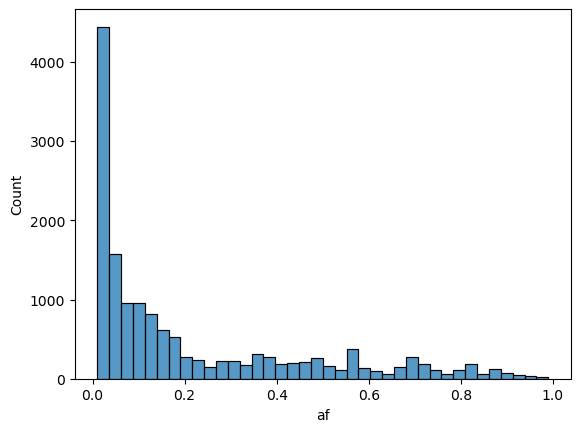

In [29]:
sns.histplot(e_nominal, x='af')

<AxesSubplot: xlabel='af', ylabel='Count'>

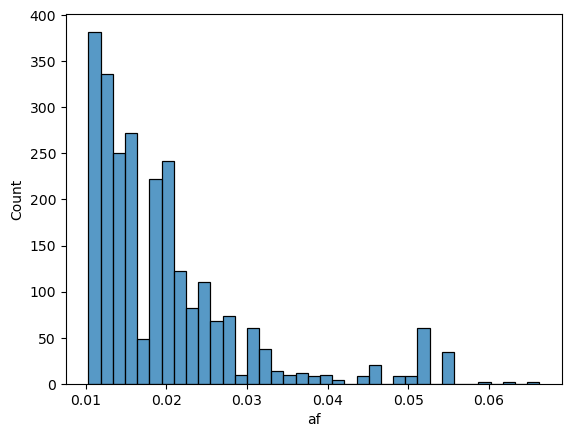

In [28]:
sns.histplot(e_nominal[~e_nominal['variant_id'].isin(gwas_cluster['panel_variant_id'])], x='af')

### coloc plots

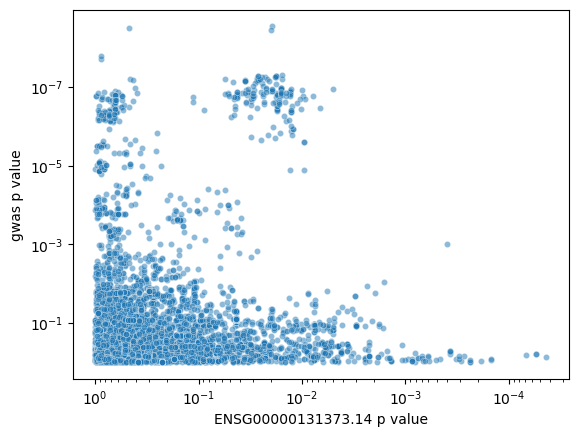

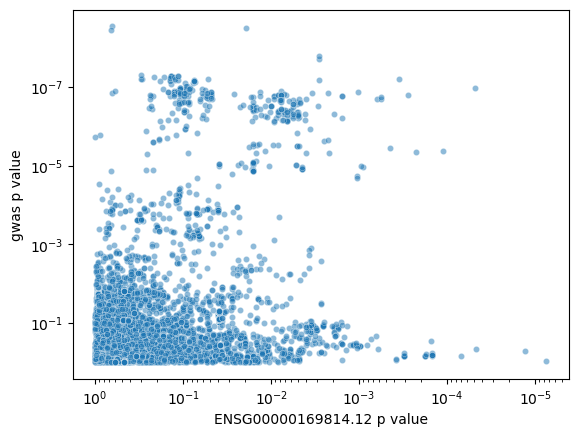

In [47]:
gwas_e_merge = pd.merge(gwas_cluster, e_nominal, left_on='panel_variant_id', right_on='variant_id')


for egene in gwas_e_merge['phenotype_id'].unique():
    egene_gwas_merge = gwas_e_merge[gwas_e_merge['phenotype_id']==egene]
    ax = sns.scatterplot(egene_gwas_merge, y='pvalue', x='pval_nominal', s=20, alpha=.5)
    ax.set_ylabel('gwas p value')
    ax.set_xlabel('{} p value'.format(egene.split('_e_')[-1]))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.show()

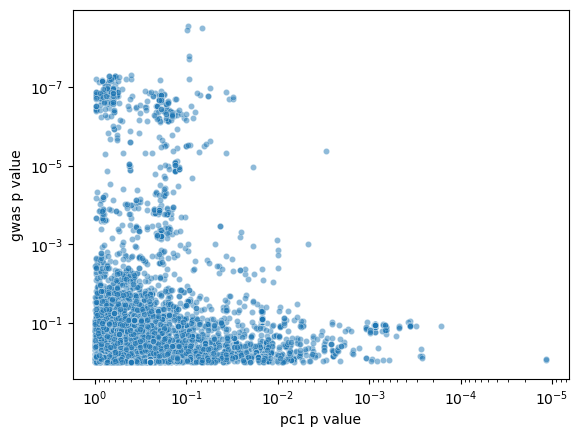

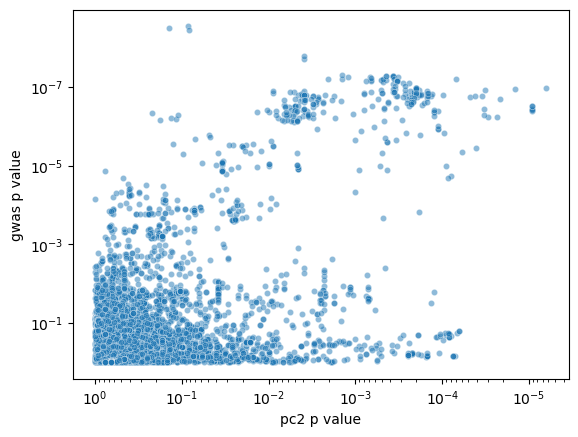

In [126]:
gwas_pc_merge = pd.merge(gwas_cluster, pc_nominal, left_on='panel_variant_id', right_on='variant_id', suffixes=['_gwas', '_pc'])


for pc_phenotype in gwas_pc_merge['phenotype_id'].unique():
    pcgene_gwas_merge = gwas_pc_merge[gwas_pc_merge['phenotype_id']==pc_phenotype]
    ax = sns.scatterplot(pcgene_gwas_merge, y='pvalue', x='pval_nominal_pc', s=20, alpha=.5)
    ax.set_ylabel('gwas p value')
    ax.set_xlabel('{} p value'.format(pc_phenotype.split('_')[-1]))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.show()

In [130]:
pcgene_gwas_merge.loc[pcgene_gwas_merge['pval_nominal_pc'].idxmin()]

variant_id_gwas                                              rs2470530
panel_variant_id                                 chr3_15647251_C_T_b38
chromosome                                                        chr3
position_gwas                                                 15647251
effect_allele                                                        T
non_effect_allele                                                    C
current_build                                                     hg38
frequency                                                     0.725108
sample_size                                                     336107
zscore                                                       -5.321427
pvalue                                                             0.0
effect_size                                                   -0.01432
standard_error                                                0.002691
imputation_status                                             original
n_case

### manhattenplots

TODO color by LD

In [55]:
susie_annot = load_susie_annotated(config, tissue_id)
susie_cluster = susie_annot[susie_annot['cluster_id']==cluster_id]

In [63]:
pc_nominal['position'] = pc_nominal['variant_id'].str.split('_').str[1].astype(int)
e_nominal['position'] = e_nominal['variant_id'].str.split('_').str[1].astype(int)
gwas_cluster['position'] = gwas_cluster['panel_variant_id'].str.split('_').str[1].astype(int)
gwas_cluster['pval_nominal'] = gwas_cluster['pvalue'] 

/local/scratch/klawren/slrmtmp.46818055/ipykernel_35143/1524257759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_cluster['position'] = gwas_cluster['panel_variant_id'].str.split('_').str[1].astype(int)
/local/scratch/klawren/slrmtmp.46818055/ipykernel_35143/1524257759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_cluster['pval_nominal'] = gwas_cluster['pvalue']


In [103]:
def plot_manhatten(nominal, susie=None):
    fig, ax = plt.subplots(figsize=(10,4))
    sns.scatterplot(nominal, x='position', y='pval_nominal', ax=ax, s=10, edgecolor=None, alpha=.7, color='k')
    ax.invert_yaxis()
    ax.set_yscale('log')
    if susie is not None:
        susie_phenotype_merge = pd.merge(nominal, susie, on='variant_id', how='right', suffixes=['_nom', ''])
        sns.scatterplot(susie_phenotype_merge, x='position', y='pval_nominal', hue='cs_id', ax=ax, s=30)
        try:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        except ValueError as e:
            # no legend
            pass
    return ax

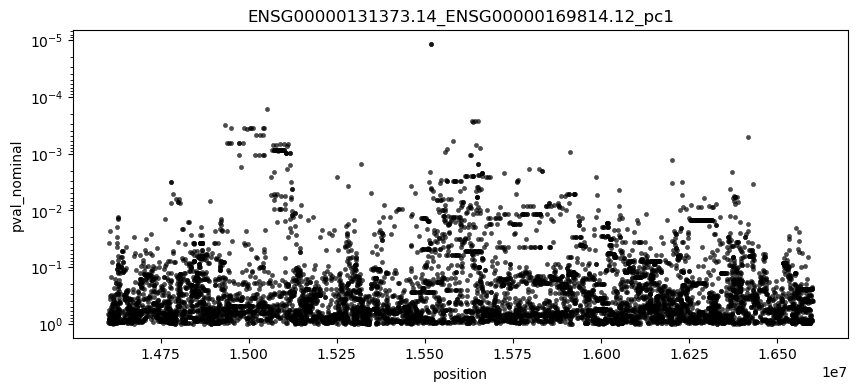

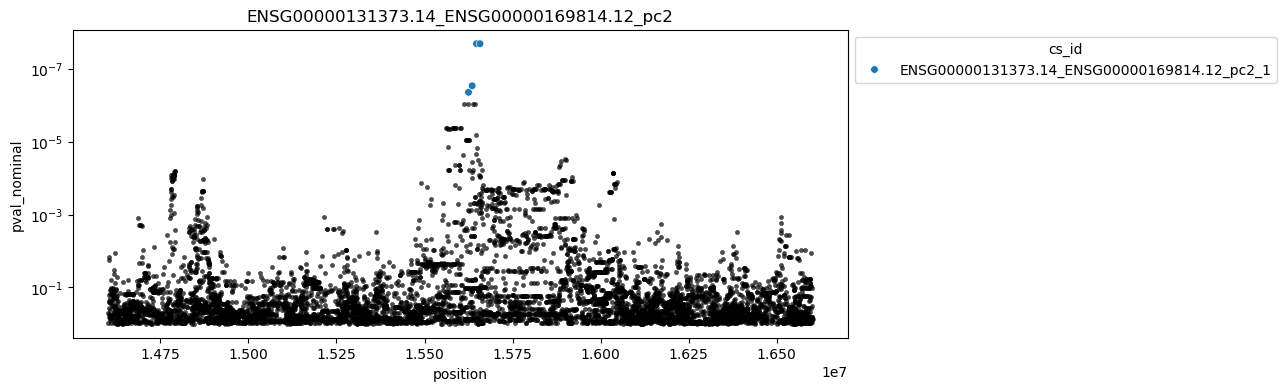

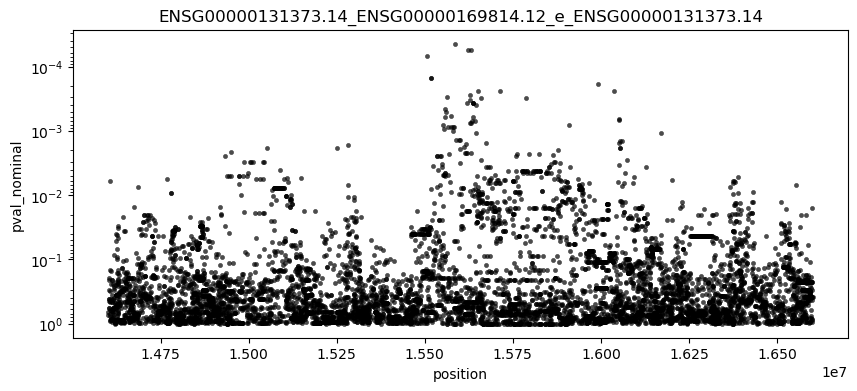

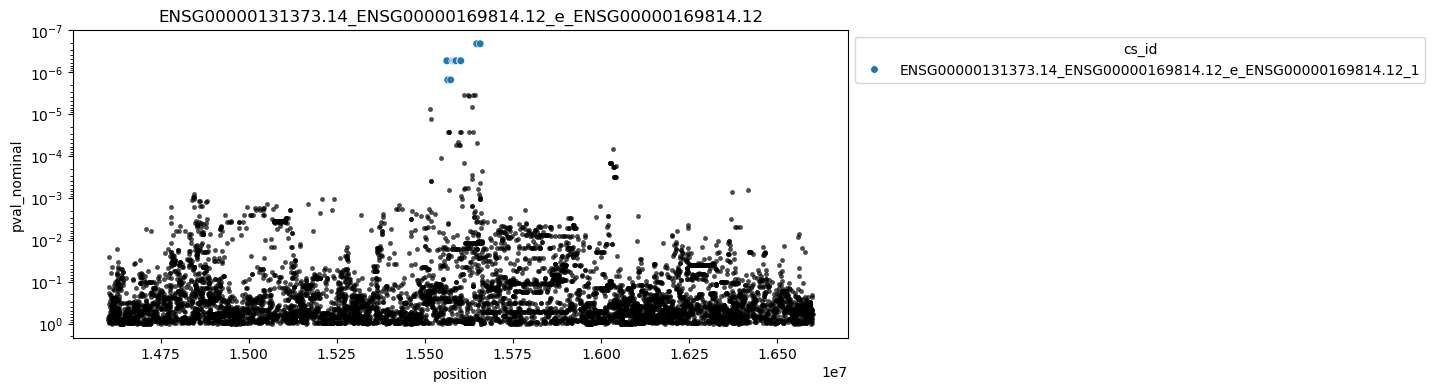

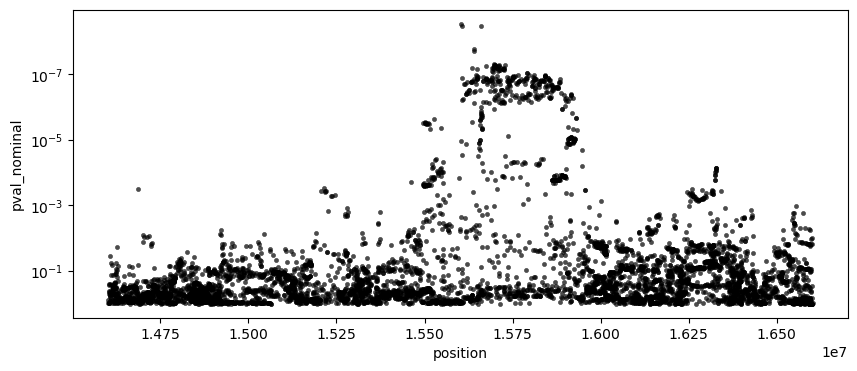

In [105]:
for pc_phenotype in pc_nominal['phenotype_id'].unique():
    ax = plot_manhatten(pc_nominal[pc_nominal['phenotype_id']==pc_phenotype], susie_cluster[susie_cluster['phenotype_id'] == pc_phenotype])
    ax.set_title(pc_phenotype)
    plt.show()

for e_phenotype in e_nominal['phenotype_id'].unique():
    ax = plot_manhatten(e_nominal[e_nominal['phenotype_id']==e_phenotype], susie_cluster[susie_cluster['phenotype_id'] == e_phenotype])
    ax.set_title(e_phenotype)
    plt.show()

plot_manhatten(gwas_cluster)
plt.show()


In [133]:
# get the position of the pc2 credible set which coloc'd
susie_coloc = susie_cluster[susie_cluster['phenotype_id']=='ENSG00000131373.14_ENSG00000169814.12_pc2']
susie_coloc

,phenotype_id,variant_id,cs_id,type,pip,cluster_id,start_distance,end_distance,af,ma_samples,...,qtl_inter,num_tads_qtl,qtl_in_tad,between_tss,qtl_in_tss_ctcf,qtl_in_tad_ctcf,in_bidirectional_promoter,in_shared_promoter,cs_num,lead_variant_id
33949,ENSG00000131373.14_ENSG00000169814.12_pc2,chr3_15624818_C_T_b38,ENSG00000131373.14_ENSG00000169814.12_pc2_1,pcqtl,0.044728,ENSG00000131373.14_ENSG00000169814.12,23624,23477,0.021515,24,...,"(15624818.0, 15629818.0]",1,False,False,False,False,False,False,1,chr3_15647551_C_T_b38
33950,ENSG00000131373.14_ENSG00000169814.12_pc2,chr3_15635155_G_C_b38,ENSG00000131373.14_ENSG00000169814.12_pc2_1,pcqtl,0.045694,ENSG00000131373.14_ENSG00000169814.12,33961,33814,0.020654,23,...,"(15635155.0, 15640155.0]",1,False,False,False,False,False,False,1,chr3_15647551_C_T_b38
33951,ENSG00000131373.14_ENSG00000169814.12_pc2,chr3_15647551_C_T_b38,ENSG00000131373.14_ENSG00000169814.12_pc2_1,pcqtl,0.431388,ENSG00000131373.14_ENSG00000169814.12,46357,46210,0.016351,18,...,"(15647551.0, 15652551.0]",1,False,False,False,False,False,False,1,chr3_15647551_C_T_b38
33952,ENSG00000131373.14_ENSG00000169814.12_pc2,chr3_15657404_A_G_b38,ENSG00000131373.14_ENSG00000169814.12_pc2_1,pcqtl,0.431388,ENSG00000131373.14_ENSG00000169814.12,56210,56063,0.016351,18,...,"(15657404.0, 15662404.0]",1,False,False,False,False,False,False,1,chr3_15647551_C_T_b38


In [114]:
susie_coloc['variant_id']

33949    chr3_15624818_C_T_b38
33950    chr3_15635155_G_C_b38
33951    chr3_15647551_C_T_b38
33952    chr3_15657404_A_G_b38
Name: variant_id, dtype: object

In [136]:
gwas_cluster[gwas_cluster['panel_variant_id'] == 'chr3_15647551_C_T_b38']

,variant_id,panel_variant_id,chromosome,position,effect_allele,non_effect_allele,current_build,frequency,sample_size,zscore,pvalue,effect_size,standard_error,imputation_status,n_cases,p_value,pval_nominal


In [112]:
gwas_cluster[gwas_cluster['panel_variant_id'].isin(susie_coloc['variant_id'])]

,variant_id,panel_variant_id,chromosome,position,effect_allele,non_effect_allele,current_build,frequency,sample_size,zscore,pvalue,effect_size,standard_error,imputation_status,n_cases,p_value,pval_nominal
